# Investigating wind referencing methods, outside func. vs ASFC

Import packages + ASFC

In [30]:
import pathlib
from pathlib import Path
import os 

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import gsw
import cmocean as cmo
import scipy
from scipy import stats
import netCDF4
from netCDF4 import Dataset as nc
import cartopy.crs as ccrs
import matplotlib
import seaborn as sns

from sklearn.metrics import mean_squared_error
import math


from AirSeaFluxCode import AirSeaFluxCode

font = {'weight' : 'normal',
        'size'  : 20}
matplotlib.rc('font', **font)

All functions

In [31]:
import math
def wind_sp_kt_to_ms(wind_kts):
    
    return wind_kts*0.514444  #kt to m/s

def wind_sp_to_10m(wind_sp, z0=1.52e-4, zm=3.4, z10=10):
    
    """Correct wind speed data from a given height to 10m above sea level.

       wind_sp = wind speed measurement (m/s)
       z0      = roughness length
       zm      = height of wind measurement
       z10     = height to correct to
    """
    
    return wind_sp*(math.log(z10/z0)/math.log(zm/z0))

def wind_direction(v, u):
    DIR=90-np.rad2deg(np.arctan(v / u) )
    return DIR

from tqdm import tqdm  # Assuming you're using the tqdm library for progress tracking

def colocate_era5_sd(sd, era5, var):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.
    - var (str): The variable to be colocated.

    Returns:
    - era5_var (numpy.ndarray): An array of ERA5 variable values colocated with SD.
    """

    # Initialize an empty array to store ERA5 variable values
    era5_var = np.ndarray(sd.time.size)

    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        era5_var[t] = era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)[var].data

    return era5_var

def era5dewtorh(era5_ds):
    # Extract dew point temperature (Dp) values from the input dataset
    Dp = era5_ds.d2m.values-273.15 # dew point temperature in celsius

    # Extract air temperature (T) values from the input dataset, and convert to celsius
    T = era5_ds.t2m.values # temperature in celsius
    
    # Calculate relative humidity (RH) using the formula and add it to the input dataset
    era5_ds['rh'] = (('time', 'latitude', 'longitude'),
                     100 * (np.exp((17.625 * Dp) / (243.04 + Dp)) / np.exp((17.625 * T) / (243.04 + T))))
    
    # Return the input dataset with the 'rh' variable added
    return era5_ds

def dist_era5_sd(sd, era5):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.

    Returns:
    - dist (numpy.ndarray): An array of distance in meters between nearest ERA5 gridpoint and SD.
    """

    # Initialize an empty array to store ERA5 variable values
    dist = np.ndarray(sd.time.size)
    #time = np.ndarray(sd.time.size)
    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        dist[t] = gsw.distance([era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['longitude'].data, sd.longitude[t]],[era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['latitude'].data, sd.latitude[t]]) 
        
        #dist[t]= (((era5.latitude[lat_idx]-sd.latitude[lat_idx])**2)+((era5.longitude[lon_idx]-sd.longitude[lon_idx])**2))**0.5
        #time[t] = era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['time']
        
        
    return dist

Load datasets

In [32]:
ds=xr.open_dataset('MasterH23/ds.nc')
ERA5=xr.open_dataset('MasterH23/ERA5file.nc')
coloc3=pd.read_csv('MasterH23/coloc3.csv') #open coloc3
dsadcpH=xr.open_dataset('MasterH23/dsadcpH.nc')


# 1. Investigation starts here

1.1 Reference wind to 10 m ONCE with outside function in variable "wind10"


1.2 Reference wind to 10 m ONCE with ASFC


1.3 Wind individually referenced with SD measurement of wind measured height in dsadcpH.WIND_CORR10

## Using the follwing function, SD wind data may be referenced to a new height


$U_{10}$= $U_m \cdot \dfrac{log \dfrac{z_{10}}{z_0}}{log \dfrac{z_m}{z_0}}$


wind_sp_to_10m(wind_sp, z0=1.52e-4, zm=3.4, z10=10) (Defined under functions above)


1.1 Reference wind to 10 m ONCE with outside function in variable . Label: FuncCorr1

In [33]:
funccorr1=wind_sp_to_10m(dsadcpH.WIND_SPEED_MEAN) #reference wind ONCE

1.2 Reference wind to 10 m ONCE with ASFC. Label: ASFCCorr1

In [34]:
hum1=dsadcpH.rh.values

spd= dsadcpH.WIND_SPEED_MEAN.values#relative windpeed
SST= dsadcpH.sst.values
T= dsadcpH.t2m.values #seasurface temperature in kelvin. Will convert iff less than 200
hum= ['rh', hum1 ] #chose rh, spec hum or dew point temp.
P= coloc3.P_SEA.values #air pressure in hPA
SST_fl ='bulk' #string, 'bulk' or 'skin' for input
meth= 'C35' #string, choose method of calcultion
lat= dsadcpH.latitude.values #latitude
hin=([3.4, 2.3, 2.3])  #sensor heights in m, 3x1 same order as output 
hout=10 #output height, default is 10m
Rl=dsadcpH.dwlw.values#longwave dwn radiation
Rs= dsadcpH.dwsw.values # shortwave dwn radiation
cskin= 1 #0 cool skin adj off
skin='C35' #'C35' #string "C35", "ecmwf" or "Beljaars"
wl=1 #warm layer off 0 (default)
gust= None# [x,beta,zi,ustbj] #Check documentation
qmeth= 'Buck2' #string, saturation evaporation method
tol= None #float, tolerance limits for fluxes and heights, check documentation
maxiter= 30 #number fo iterations
out= 0 #int, set 0 to set points thathave not converged
out_var= None #str, define pandas arrayod variables for output. There i a default for cskin and gust off. Check documentation
L=None #str, M-O definition option. 'tsrv' is default

ASFC=AirSeaFluxCode(spd, T, SST, SST_fl, meth, lat=lat, hum=hum, P=P,
                   hin=hin, hout=hout, Rl=Rl, Rs=Rs, cskin=cskin, skin=skin, wl=wl,
                   gust=gust, qmeth=qmeth, tol=tol, maxiter=maxiter, out=out,
                   out_var=out_var, L=L)



In [35]:
asfccorr1=ASFC.uref #Safe ASFC referenced winds in urefe

1.3 dsadcpH.WIND_CORR10, already referenced per individual height in for loop with outside function Label: FuncCorrInd

In [36]:
funccorrind=dsadcpH.WIND_CORR10

1.4 Input already individual referenced windvalues (1.3 WIND_CORR10) with same output height. Label: 10in10out

In [37]:
hum1=dsadcpH.rh.values

spd= dsadcpH.WIND_CORR10.values#relative windpeed
SST= dsadcpH.sst.values
T= dsadcpH.t2m.values #seasurface temperature in kelvin. Will convert iff less than 200
hum= ['rh', hum1 ] #chose rh, spec hum or dew point temp.
P= coloc3.P_SEA.values #air pressure in hPA
SST_fl ='bulk' #string, 'bulk' or 'skin' for input
meth= 'C35' #string, choose method of calcultion
lat= dsadcpH.latitude.values #latitude
hin=([10, 2.3, 2.3])  #sensor heights in m, 3x1 same order as output 
hout=10 #output height, default is 10m
Rl=dsadcpH.dwlw.values#longwave dwn radiation
Rs= dsadcpH.dwsw.values # shortwave dwn radiation
cskin= 1 #0 cool skin adj off
skin='C35' #'C35' #string "C35", "ecmwf" or "Beljaars"
wl=1 #warm layer off 0 (default)
gust= None# [x,beta,zi,ustbj] #Check documentation
qmeth= 'Buck2' #string, saturation evaporation method
tol= None #float, tolerance limits for fluxes and heights, check documentation
maxiter= 30 #number fo iterations
out= 0 #int, set 0 to set points thathave not converged
out_var= None #str, define pandas arrayod variables for output. There i a default for cskin and gust off. Check documentation
L=None #str, M-O definition option. 'tsrv' is default

ASFC=AirSeaFluxCode(spd, T, SST, SST_fl, meth, lat=lat, hum=hum, P=P,
                   hin=hin, hout=hout, Rl=Rl, Rs=Rs, cskin=cskin, skin=skin, wl=wl,
                   gust=gust, qmeth=qmeth, tol=tol, maxiter=maxiter, out=out,
                   out_var=out_var, L=L)

In [39]:
tenintenout=ASFC.uref

1.1: FuncCorr1


1.2: ASFCCorr1


1.3: FuncCorrInd


1.4: 10in10out

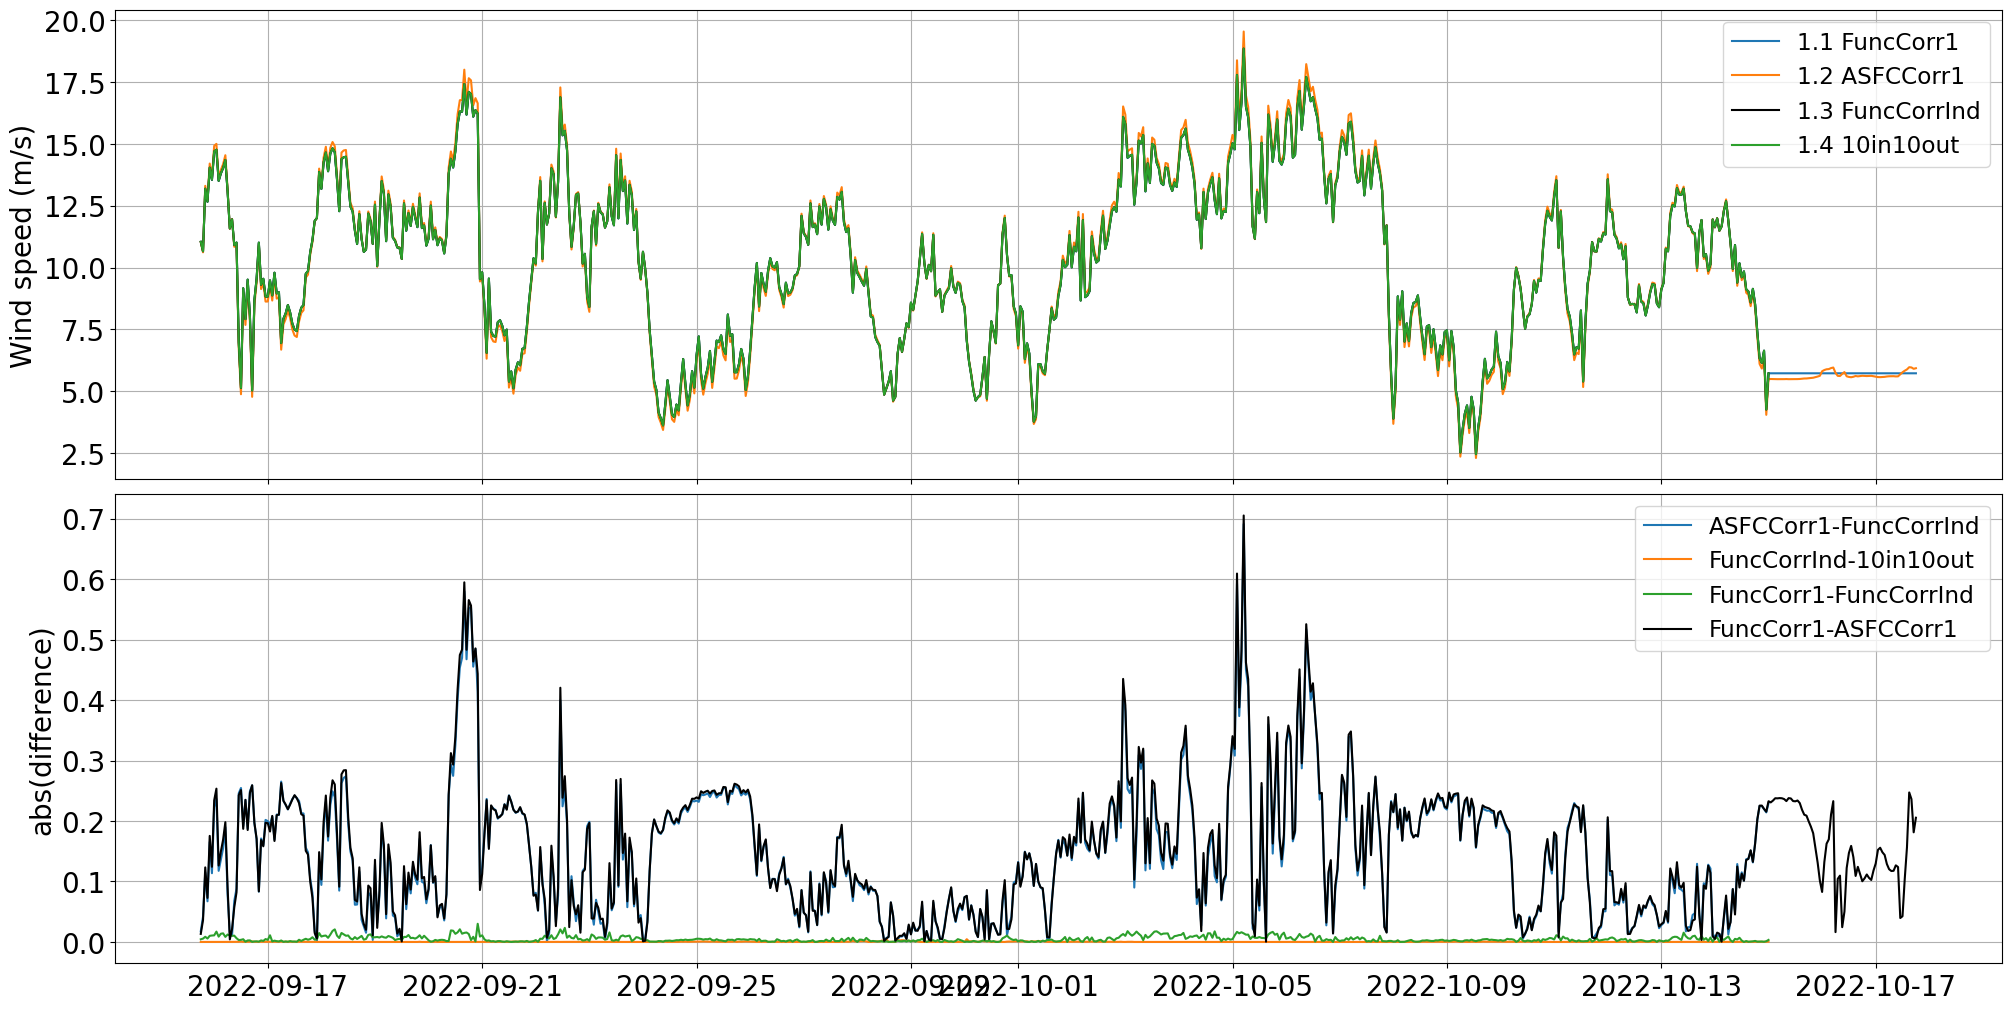

In [50]:
fig,ax=plt.subplots(2,1,figsize=[20,10], constrained_layout=True, sharex=True)


ax[0].plot(dsadcpH.time, funccorr1, label=('1.1 FuncCorr1'))
ax[0].plot(dsadcpH.time, asfccorr1, label=('1.2 ASFCCorr1'))
ax[0].plot(dsadcpH.time, funccorrind, label=('1.3 FuncCorrInd'), color='k')
#ax.plot(dsadcpH.time, dsadcpH.WIND_SPEED_MEAN, label=('Original SD data'))
ax[0].plot(dsadcpH.time, tenintenout, label=('1.4 10in10out'))


ax[1].plot(dsadcpH.time, np.abs(asfccorr1-funccorrind), label=('ASFCCorr1-FuncCorrInd'))

ax[1].plot(dsadcpH.time, np.abs(funccorrind-tenintenout), label=('FuncCorrInd-10in10out'))

ax[1].plot(dsadcpH.time, np.abs(funccorr1-funccorrind), label=('FuncCorr1-FuncCorrInd'))

ax[1].plot(dsadcpH.time, np.abs(funccorr1-asfccorr1), label=('FuncCorr1-ASFCCorr1'), color='k')



#ax[1].plot(dsadcpH.time, np.abs(), label=(''))

#ax[1].plot(dsadcpH.time, np.abs(), label=(''))

ax[1].set_ylabel('abs(difference)')
ax[0].set_ylabel('Wind speed (m/s)')

for i in np.arange(2):
    ax[i].grid()
    ax[i].legend(fontsize='small')

plt.savefig('figures/fluxfocuswindcorr.png')

Differences of ASFC wind referencing vs the outside function shows relatively big compared to the effect of using individual wind measurement heights. A maximum difference of around 0.7 m/s is abundant in the functions. This could have an impact on variability.


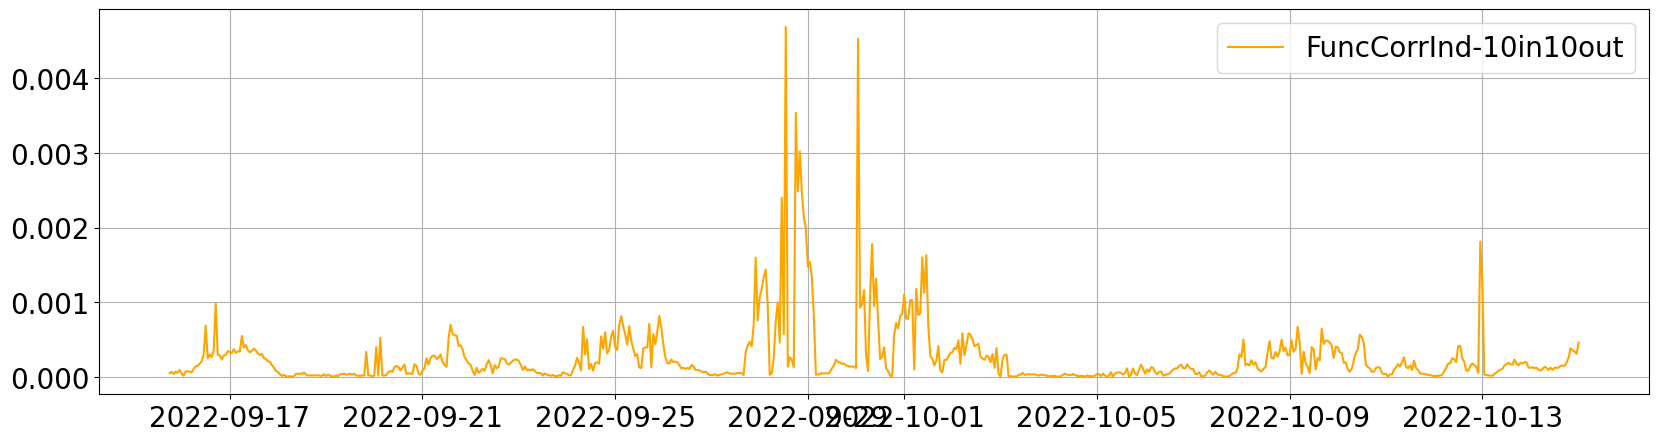

In [58]:
fig, ax= plt.subplots(1,1, figsize=[20,5])




#ax.plot(dsadcpH.time, np.abs(funccorr1-funccorrind), label=('FuncCorr1-FuncCorrInd'), color='green')
ax.plot(dsadcpH.time, np.abs(funccorrind-tenintenout), label=('FuncCorrInd-10in10out'), color='orange')

ax.grid()
ax.legend()

The surprising feature here is the small difference in the data ASFC output wih 10 m inut and 10 m ouput. What else except adiabatic lapse rate is going into the wind referencing? Gustiness, even if its off? 